# Website for EIP-1559 and base fee calculation
https://tokenview.medium.com/how-to-build-a-gas-fee-estimator-for-eip-1559-using-python-2033935d9fd2

In [1]:
import os
import re
from time import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import calendar

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_joined.csv').drop(columns='Unnamed: 0')
df['datetime'] = pd.to_datetime(df['datetime'])

In [3]:
df['gas_used_block_real'] = df['gas_used_block'].shift(-1)
df = df.dropna(subset='gas_used_block_real')
df = df[['block_number', 'avg_receipt_gas_used', 'total_value_transactions',
       'avg_value_transactions', 'datetime', 'size', 'gas_limit',
       'transaction_count', 'gas_used_block', 'Volume', 'Close', 'RSI_adj', 'MACD',
       'MACD_exponential_MA_9', 'Ethereum', 'Solana','gas_used_block_real']]
df = df[df['datetime'] >= '2022-04-08 13:00:00']


In [4]:
df['total_value_transactions'] = df['total_value_transactions'].apply(lambda x: float(x))

# Feature engineering and selection trial

In [5]:
df_fe = df.copy()

for i in range(1,5):
    df_fe['gas_used_block_real_pct_' + str(i)] = df_fe['gas_used_block_real'].pct_change(i)
    df_fe['transaction_count_pct_' + str(i)] = df_fe['transaction_count'].pct_change(i)
    for j in range(3,5):
        df_fe['gas_used_block_real_pct_' + str(i) + '_ewm_' + str(j)] = df_fe['gas_used_block_real_pct_' + str(i)].ewm(span=j, adjust=False).mean()
        df_fe['transaction_count_pct_' + str(i) + '_ewm_' + str(j)] = df_fe['transaction_count_pct_' + str(i)].ewm(span=j, adjust=False).mean()


In [8]:
import numpy as np
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import catboost as cb
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.impute import KNNImputer

# Sample data
y = df_fe['gas_used_block_real']
X = df_fe[['avg_receipt_gas_used', 'total_value_transactions',
       'avg_value_transactions', 'size', 'gas_limit',
       'transaction_count', 'gas_used_block', 'Volume', 'Close', 'RSI_adj',
       'MACD', 'MACD_exponential_MA_9', 'Ethereum', 'Solana', 'gas_used_block_real_pct_1',
       'transaction_count_pct_1', 'gas_used_block_real_pct_1_ewm_3',
       'transaction_count_pct_1_ewm_3', 'gas_used_block_real_pct_1_ewm_4',
       'transaction_count_pct_1_ewm_4', 'gas_used_block_real_pct_2',
       'transaction_count_pct_2', 'gas_used_block_real_pct_2_ewm_3',
       'transaction_count_pct_2_ewm_3', 'gas_used_block_real_pct_2_ewm_4',
       'transaction_count_pct_2_ewm_4', 'gas_used_block_real_pct_3',
       'transaction_count_pct_3', 'gas_used_block_real_pct_3_ewm_3',
       'transaction_count_pct_3_ewm_3', 'gas_used_block_real_pct_3_ewm_4',
       'transaction_count_pct_3_ewm_4', 'gas_used_block_real_pct_4',
       'transaction_count_pct_4', 'gas_used_block_real_pct_4_ewm_3',
       'transaction_count_pct_4_ewm_3', 'gas_used_block_real_pct_4_ewm_4',
       'transaction_count_pct_4_ewm_4']]


# XGBoost model
model = cb.CatBoostRegressor()
model.fit(X, y, verbose=False)




In [ ]:

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(30, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')


Text(0.5, 1.0, 'Feature Importance')

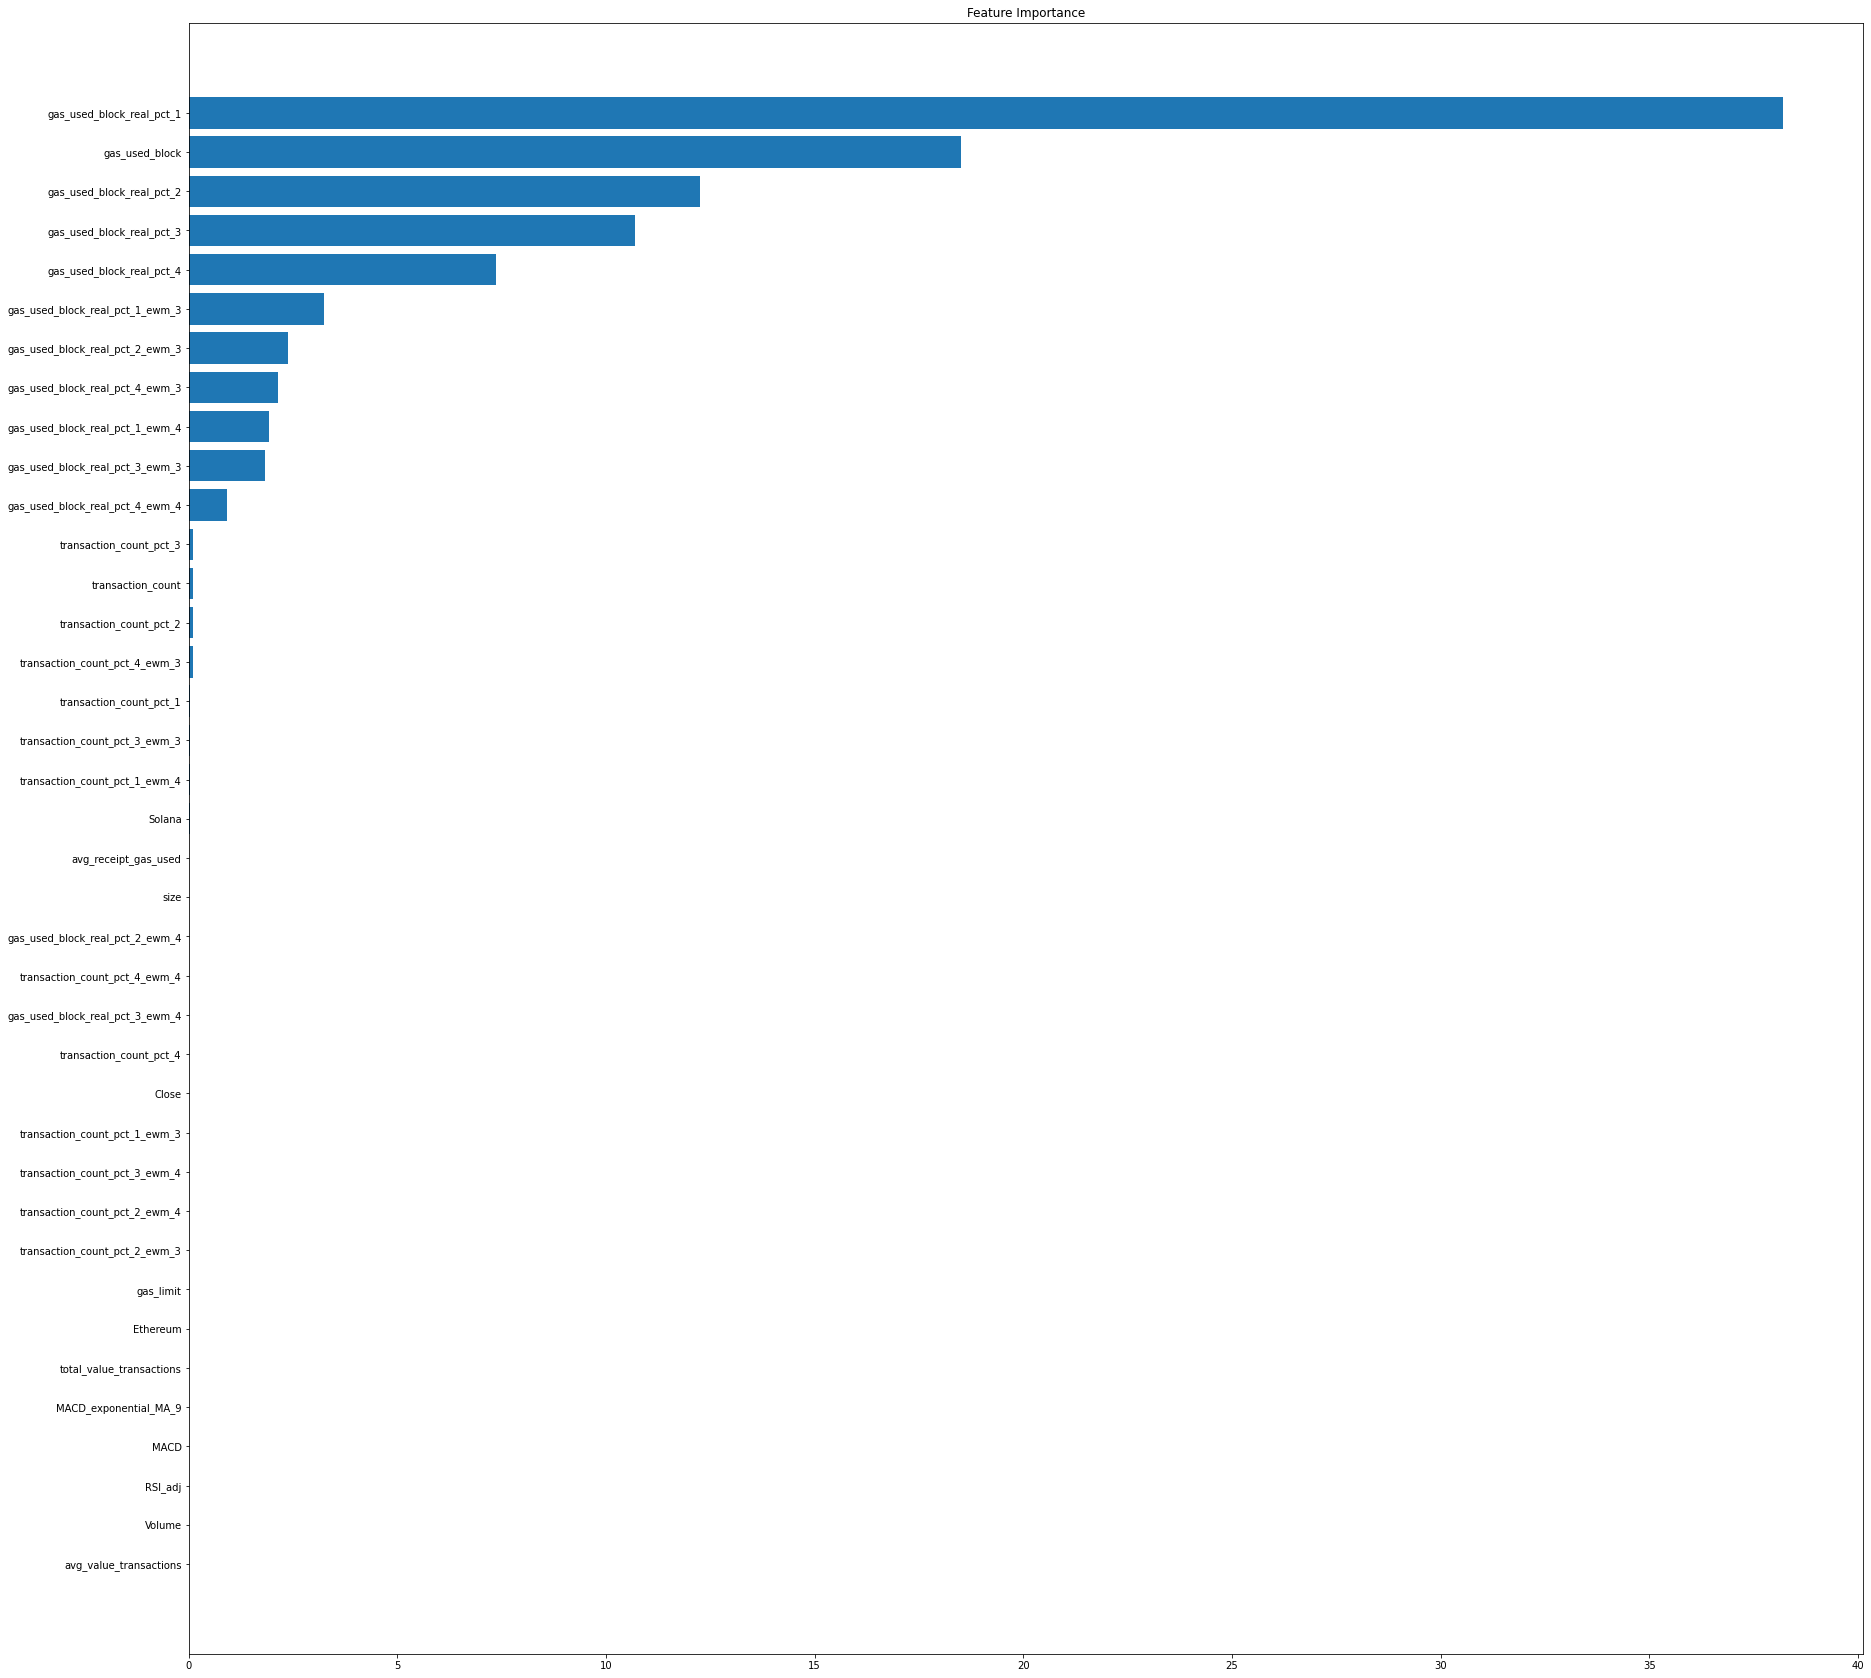

In [9]:

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(30, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')


In [10]:
var_pool = ['avg_receipt_gas_used', 'total_value_transactions',
       'avg_value_transactions', 'size', 'gas_limit',
       'transaction_count', 'gas_used_block', 'Volume', 'Close', 'RSI_adj',
       'MACD', 'MACD_exponential_MA_9', 'Ethereum', 'Solana', 'gas_used_block_real_pct_1',
       'transaction_count_pct_1', 'gas_used_block_real_pct_1_ewm_3',
       'transaction_count_pct_1_ewm_3', 'gas_used_block_real_pct_1_ewm_4',
       'transaction_count_pct_1_ewm_4', 'gas_used_block_real_pct_2',
       'transaction_count_pct_2', 'gas_used_block_real_pct_2_ewm_3',
       'transaction_count_pct_2_ewm_3', 'gas_used_block_real_pct_2_ewm_4',
       'transaction_count_pct_2_ewm_4', 'gas_used_block_real_pct_3',
       'transaction_count_pct_3', 'gas_used_block_real_pct_3_ewm_3',
       'transaction_count_pct_3_ewm_3', 'gas_used_block_real_pct_3_ewm_4',
       'transaction_count_pct_3_ewm_4', 'gas_used_block_real_pct_4',
       'transaction_count_pct_4', 'gas_used_block_real_pct_4_ewm_3',
       'transaction_count_pct_4_ewm_3', 'gas_used_block_real_pct_4_ewm_4',
       'transaction_count_pct_4_ewm_4']
vars_selected = []

for i in range(25):
    cur_var_index = sorted_idx[len(var_pool) - 1 - i]
    vars_selected.append(var_pool[cur_var_index])

In [11]:
vars_selected

['gas_used_block_real_pct_1',
 'gas_used_block',
 'gas_used_block_real_pct_2',
 'gas_used_block_real_pct_3',
 'gas_used_block_real_pct_4',
 'gas_used_block_real_pct_1_ewm_3',
 'gas_used_block_real_pct_2_ewm_3',
 'gas_used_block_real_pct_4_ewm_3',
 'gas_used_block_real_pct_1_ewm_4',
 'gas_used_block_real_pct_3_ewm_3',
 'gas_used_block_real_pct_4_ewm_4',
 'transaction_count_pct_3',
 'transaction_count',
 'transaction_count_pct_2',
 'transaction_count_pct_4_ewm_3',
 'transaction_count_pct_1',
 'transaction_count_pct_3_ewm_3',
 'transaction_count_pct_1_ewm_4',
 'Solana',
 'avg_receipt_gas_used',
 'size',
 'gas_used_block_real_pct_2_ewm_4',
 'transaction_count_pct_4_ewm_4',
 'gas_used_block_real_pct_3_ewm_4',
 'transaction_count_pct_4']

In [12]:
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.impute import KNNImputer

cbr_hyper_rmse_r2_list = []

df = df_fe.copy().dropna(subset='gas_used_block_real')

start_time = time()
for d in [3,4,5,6]:
    for cbr_iter in np.arange(100,410,50):
    # for cbr_iter in [150]:
        # print('########## working on cbr_iter %d ##########'%cbr_iter)
        for niter in range(5):
        # for niter in [0]:
            # tmp_time = time()
            print('----- working on d %d, cbr_iter %d, niter %d -----'%(d, cbr_iter, niter))
            oot = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=0+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=1+niter)))]
            tst = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=1+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=3+niter)))]
            trn = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=3+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=12+niter)))]

            x_trn = trn[vars_selected]
            x_tst = tst[vars_selected]
            x_oot = oot[vars_selected]

        ############################################################
            # preprocessing
            # winsorization
            trn_pctil_95 = x_trn[vars_selected].quantile(0.95)
            trn_pctil_10 = x_trn[vars_selected].quantile(0.1)

            x_tst = x_tst.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
            x_oot = x_oot.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
            x_trn = x_trn.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)

            # Normalization and standardize to [-1,1]
            x_tst = (x_tst - x_trn.mean()) / x_trn.std()
            x_tst = 2 * (x_tst - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

            x_oot = (x_oot - x_trn.mean()) / x_trn.std()
            x_oot = 2 * (x_oot - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

            x_trn = (x_trn - x_trn.mean()) / x_trn.std()
            x_trn = 2 * (x_trn - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

            # impute for missing values
            x_tst.fillna(x_trn.mean(),inplace=True)
            x_oot.fillna(x_trn.mean(),inplace=True)
            x_trn.fillna(x_trn.mean(),inplace=True)
            
            # print('working on knn imputer')
            # # KNN imputation is taking too much time, ignore for now
            # imputer = KNNImputer(n_neighbors=3)
            # imputer.fit(x_trn)
            
            # x_trn = imputer.transform(x_trn)
            # x_tst = imputer.transform(x_tst)
            # x_oot = imputer.transform(x_oot)
        ############################################################
            print('Preprocessing Finished')
            y_oot = oot['gas_used_block_real']
            y_tst = tst['gas_used_block_real']
            y_trn = trn['gas_used_block_real']

            # rf = RandomForestRegressor(n_estimators=100, criterion='gini', max_depth=15, min_samples_split=20, min_samples_leaf=200, max_features='log2')
            cbr = CatBoostRegressor(verbose=0, depth=d, iterations=cbr_iter, learning_rate=0.01, l2_leaf_reg=5, random_seed=42)
            cbr.fit(x_trn, y_trn)

            cbr_predictions_trn = cbr.predict(x_trn)
            rmse_trn = np.sqrt(mean_squared_error(y_trn, cbr_predictions_trn))

            cbr_predictions_tst = cbr.predict(x_tst)
            rmse_tst = np.sqrt(mean_squared_error(y_tst, cbr_predictions_tst))

            cbr_predictions_oot = cbr.predict(x_oot)
            rmse_oot = np.sqrt(mean_squared_error(y_oot, cbr_predictions_oot))
            # cbr_rmse_list.append([rmse_trn, rmse_tst, rmse_oot, cbr.score(x_trn, y_trn)])
            cbr_hyper_rmse_r2_list.append([cbr_iter, d, rmse_trn, rmse_tst, rmse_oot, cbr.score(x_trn, y_trn)])
            print('cbr finished')
            

----- working on d 3, cbr_iter 100, niter 0 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 100, niter 1 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 100, niter 2 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 100, niter 3 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 100, niter 4 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 150, niter 0 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 150, niter 1 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 150, niter 2 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 150, niter 3 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 150, niter 4 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 200, niter 0 -----
Preprocessing Finished
cbr finished
----- working on d 3, cbr_iter 200, niter 1 -----
Prep

In [13]:
cbr_hyper_rmse_r2_df = pd.DataFrame(cbr_hyper_rmse_r2_list, columns=['cbr_iter','d','trn_rmse','tst_rmse','oot_rmse','trn_r2'])
cbr_hyper_rmse_r2_df.to_csv('block_level_cbr_hyper_rmse_r2_df.csv')

In [14]:
cbr_hyper_rmse_r2_df.groupby(['cbr_iter', 'd']).mean()

trn_rmse      tst_rmse      oot_rmse    trn_r2
cbr_iter d                                                    
100      3  3.381275e+06  2.889230e+06  2.919745e+06  0.651759
         4  3.184024e+06  2.827789e+06  2.847468e+06  0.691116
         5  3.031182e+06  2.850125e+06  2.864532e+06  0.720049
         6  2.922257e+06  2.881157e+06  2.897277e+06  0.739857
150      3  2.796021e+06  2.607712e+06  2.618529e+06  0.761748
         4  2.562951e+06  2.822452e+06  2.824373e+06  0.799760
         5  2.383910e+06  3.080989e+06  3.081322e+06  0.826790
         6  2.242199e+06  3.382149e+06  3.383837e+06  0.846860
200      3  2.396020e+06  2.716575e+06  2.714106e+06  0.824972
         4  2.154137e+06  3.232248e+06  3.222400e+06  0.858490
         5  1.953617e+06  3.703877e+06  3.694956e+06  0.883645
         6  1.810321e+06  4.124197e+06  4.118225e+06  0.900123
250      3  2.116587e+06  3.001930e+06  2.989152e+06  0.863405
         4  1.881971e+06  3.776186e+06  3.759385e+06  0.891945
         5  1.668978e+06  4.395657e+06  4.383053e+06  0.915082
         6  1.525380e+06  4.861132e+06  4.851336e+06  0.929101
300      3  1.931872e+06  3.321703e+06  3.301763e+06  0.886205
         4  1.697446e+06  4.300426e+06  4.279276e+06  0.912093
         5  1.493401e+06  4.936964e+06  4.922125e+06  0.932011
         6  1.352614e+06  5.395062e+06  5.384702e+06  0.944260
350      3  1.797829e+06  3.699727e+06  3.675652e+06  0.901450
         4  1.569829e+06  4.754720e+06  4.731651e+06  0.924796
         5  1.378661e+06  5.337872e+06  5.322851e+06  0.942057
         6  1.246233e+06  5.773784e+06  5.764296e+06  0.952688
400      3  1.690588e+06  4.094465e+06  4.067477e+06  0.912841
         4  1.470797e+06  5.172023e+06  5.148234e+06  0.933992
         5  1.298279e+06  5.653476e+06  5.639964e+06  0.948617
         6  1.174056e+06  6.049930e+06  6.042600e+06  0.958013

In [16]:
cbr_hyper_rmse_r2_df.groupby(['cbr_iter', 'd']).mean()

trn_rmse      tst_rmse      oot_rmse    trn_r2
cbr_iter d                                                    
100      3  3.381275e+06  2.889230e+06  2.919745e+06  0.651759
         4  3.184024e+06  2.827789e+06  2.847468e+06  0.691116
         5  3.031182e+06  2.850125e+06  2.864532e+06  0.720049
         6  2.922257e+06  2.881157e+06  2.897277e+06  0.739857
150      3  2.796021e+06  2.607712e+06  2.618529e+06  0.761748
         4  2.562951e+06  2.822452e+06  2.824373e+06  0.799760
         5  2.383910e+06  3.080989e+06  3.081322e+06  0.826790
         6  2.242199e+06  3.382149e+06  3.383837e+06  0.846860
200      3  2.396020e+06  2.716575e+06  2.714106e+06  0.824972
         4  2.154137e+06  3.232248e+06  3.222400e+06  0.858490
         5  1.953617e+06  3.703877e+06  3.694956e+06  0.883645
         6  1.810321e+06  4.124197e+06  4.118225e+06  0.900123
250      3  2.116587e+06  3.001930e+06  2.989152e+06  0.863405
         4  1.881971e+06  3.776186e+06  3.759385e+06  0.891945
         5  1.668978e+06  4.395657e+06  4.383053e+06  0.915082
         6  1.525380e+06  4.861132e+06  4.851336e+06  0.929101
300      3  1.931872e+06  3.321703e+06  3.301763e+06  0.886205
         4  1.697446e+06  4.300426e+06  4.279276e+06  0.912093
         5  1.493401e+06  4.936964e+06  4.922125e+06  0.932011
         6  1.352614e+06  5.395062e+06  5.384702e+06  0.944260
350      3  1.797829e+06  3.699727e+06  3.675652e+06  0.901450
         4  1.569829e+06  4.754720e+06  4.731651e+06  0.924796
         5  1.378661e+06  5.337872e+06  5.322851e+06  0.942057
         6  1.246233e+06  5.773784e+06  5.764296e+06  0.952688
400      3  1.690588e+06  4.094465e+06  4.067477e+06  0.912841
         4  1.470797e+06  5.172023e+06  5.148234e+06  0.933992
         5  1.298279e+06  5.653476e+06  5.639964e+06  0.948617
         6  1.174056e+06  6.049930e+06  6.042600e+06  0.958013

In [15]:
cbr_hyper_rmse_r2_df.groupby(['cbr_iter', 'd']).mean().to_csv('block_level_cbr_hyper_rmse_r2_df_groupby.csv')

# (150,3) seems to be a great combination. Use this hyperparameter to get the final model

In [23]:
input_df = df[(df['datetime'] >= '2023-01-01 00:00:00') & (df['datetime'] < '2024-01-01 00:00:00')]
input_x = input_df[vars_selected]
input_y = input_df['gas_used_block_real']


In [24]:
# Preprocess
# Winsorization
pctil_95 = input_x.quantile(0.95)
pctil_10 = input_x.quantile(0.10)

input_x = input_x.clip(lower=pctil_10, upper=pctil_95, axis=1)

# Normalization and standardize to [-1,1]
input_x_mean = input_x.mean()
input_x_std = input_x.std()
input_x_max = input_x.max()
input_x_min = input_x.min()

input_x = (input_x - input_x.mean()) / input_x.std()
input_x = 2 * (input_x - input_x.min()) / (input_x.max() - input_x.min()) - 1

# fill na
fillna_mean = input_x.mean()
input_x.fillna(input_x.mean(),inplace=True)

In [25]:
cbr = CatBoostRegressor(verbose=0, depth=3, iterations=150, learning_rate=0.01, l2_leaf_reg=5, random_seed=42)
cbr.fit(input_x, input_y)


In [26]:
predict_x = df[df['datetime'] >= '2024-01-01 00:00:00'][vars_selected]
predict_x = predict_x.clip(lower=pctil_10, upper=pctil_95, axis=1)

predict_x = (predict_x - input_x_mean) / input_x_std
predict_x = 2 * (predict_x - input_x_min) / (input_x_max - input_x_min) - 1

# fill na
# predict_x.fillna(fillna_mean,inplace=True)

In [27]:
cbr.predict(predict_x)

array([20549588.172664  , 10469758.36392568, 12252433.87538024, ...,
       16996549.21185774, 17756072.64814427, 24700144.8749254 ])

# The main code ends here.

# Data is bascially prepared. Next step is to declare and try multiple different models. To avoid look-ahead bias, preprocessing should be conducted in the given time frame in each iteration.

5 times rolling and take average. Retrain every month.

In [34]:
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.impute import KNNImputer

cbr_hyper_rmse_r2_list = []
# cbr_rmse_list = []
rf_rmse_list = []
gbr_rmse_list = []
cbr_r2_list = []

start_time = time()
for cbr_iter in np.arange(150,400,50):
    cbr_rmse_list = []
    # print('########## working on cbr_iter %d ##########'%cbr_iter)
    for niter in range(10):
        tmp_time = time()
        print('----- working on cbr_iter %d, niter %d -----'%(cbr_iter, niter))
        oot = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=0+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=1+niter)))]
        tst = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=1+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=3+niter)))]
        trn = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=3+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=12+niter)))]

        x_trn = trn[variables]
        x_tst = tst[variables]
        x_oot = oot[variables]

    ############################################################
        # preprocessing
        # winsorization
        trn_pctil_95 = x_trn[variables].quantile(0.95)
        trn_pctil_10 = x_trn[variables].quantile(0.1)

        x_tst = x_tst.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
        x_oot = x_oot.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
        x_trn = x_trn.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)

        # Normalization and standardize to [-1,1]
        x_tst = (x_tst - x_trn.mean()) / x_trn.std()
        x_tst = 2 * (x_tst - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

        x_oot = (x_oot - x_trn.mean()) / x_trn.std()
        x_oot = 2 * (x_oot - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

        x_trn = (x_trn - x_trn.mean()) / x_trn.std()
        x_trn = 2 * (x_trn - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

        # impute for missing values
        x_tst.fillna(x_trn.mean())
        x_oot.fillna(x_trn.mean())
        x_trn.fillna(x_trn.mean())
        
        # print('working on knn imputer')
        # # KNN imputation is taking too much time, ignore for now
        # imputer = KNNImputer(n_neighbors=3)
        # imputer.fit(x_trn)
        
        # x_trn = imputer.transform(x_trn)
        # x_tst = imputer.transform(x_tst)
        # x_oot = imputer.transform(x_oot)
    ############################################################
        print('Preprocessing Finished')
        y_oot = oot['gas_used_block_real']
        y_tst = tst['gas_used_block_real']
        y_trn = trn['gas_used_block_real']

        rf = RandomForestRegressor(n_estimators=100, criterion='gini', max_depth=15, min_samples_split=20, min_samples_leaf=200, max_features='log2')
        cbr = CatBoostRegressor(verbose=0, depth=4, iterations=cbr_iter, learning_rate=0.01, l2_leaf_reg=5, random_seed=42)
        cbr.fit(x_trn, y_trn)

        cbr_predictions_trn = cbr.predict(x_trn)
        rmse_trn = np.sqrt(mean_squared_error(y_trn, cbr_predictions_trn))

        cbr_predictions_tst = cbr.predict(x_tst)
        rmse_tst = np.sqrt(mean_squared_error(y_tst, cbr_predictions_tst))

        cbr_predictions_oot = cbr.predict(x_oot)
        rmse_oot = np.sqrt(mean_squared_error(y_oot, cbr_predictions_oot))
        # cbr_rmse_list.append([rmse_trn, rmse_tst, rmse_oot, cbr.score(x_trn, y_trn)])
        cbr_hyper_rmse_r2_list.append([cbr_iter, rmse_trn, rmse_tst, rmse_oot, cbr.score(x_trn, y_trn)])
        print('cbr finished')
        

        # rf.fit(x_trn, y_trn)
        # rf_predictions_trn = cbr.predict(x_trn)
        # rmse_trn = np.sqrt(mean_squared_error(y_trn, rf_predictions_trn))

        # rf_predictions_tst = cbr.predict(x_tst)
        # rmse_tst = np.sqrt(mean_squared_error(y_tst, rf_predictions_trn))

        # rf_predictions_oot = cbr.predict(x_oot)
        # rmse_oot = np.sqrt(mean_squared_error(y_oot, rf_predictions_trn))
        # rf_rmse_list.append([rmse_trn, rmse_tst, rmse_oot])

----- working on cbr_iter 150, niter 0 -----
Preprocessing Finished
cbr finished
----- working on cbr_iter 150, niter 1 -----
Preprocessing Finished
cbr finished
----- working on cbr_iter 150, niter 2 -----
Preprocessing Finished
cbr finished
----- working on cbr_iter 150, niter 3 -----
Preprocessing Finished
cbr finished
----- working on cbr_iter 150, niter 4 -----
Preprocessing Finished
cbr finished
----- working on cbr_iter 150, niter 5 -----
Preprocessing Finished
cbr finished
----- working on cbr_iter 150, niter 6 -----
Preprocessing Finished
cbr finished
----- working on cbr_iter 150, niter 7 -----
Preprocessing Finished
cbr finished
----- working on cbr_iter 150, niter 8 -----
Preprocessing Finished
cbr finished
----- working on cbr_iter 150, niter 9 -----
Preprocessing Finished
cbr finished
----- working on cbr_iter 200, niter 0 -----
Preprocessing Finished
cbr finished
----- working on cbr_iter 200, niter 1 -----
Preprocessing Finished
cbr finished
----- working on cbr_iter 20

In [35]:
cbr_hyper_rmse_r2_df = pd.DataFrame(cbr_hyper_rmse_r2_list, columns=['cbr_iter','trn_rmse','tst_rmse','oot_rmse','trn_r2'])
cbr_hyper_rmse_r2_df

,cbr_iter,trn_rmse,tst_rmse,oot_rmse,trn_r2
0,150,2.782024e+06,2.770618e+06,2.883794e+06,0.733338
1,150,2.857700e+06,2.860674e+06,2.839102e+06,0.730365
2,150,2.927927e+06,2.986737e+06,2.802875e+06,0.731958
3,150,3.008148e+06,2.939095e+06,3.014518e+06,0.736073
4,150,3.169673e+06,2.960967e+06,3.141341e+06,0.742985
5,150,3.453432e+06,3.361503e+06,3.149642e+06,0.733832
6,150,3.863172e+06,3.761008e+06,3.707389e+06,0.722203
7,150,4.145798e+06,4.129446e+06,4.336727e+06,0.719163
8,150,4.409442e+06,4.391907e+06,3.917939e+06,0.717369
9,150,4.634523e+06,4.307440e+06,4.693232e+06,0.718745


In [37]:
cbr_hyper_rmse_r2_df.groupby('cbr_iter').mean()

,trn_rmse,tst_rmse,oot_rmse,trn_r2
cbr_iter,,,,
150,3.525184e+06,3.446939e+06,3.448656e+06,0.728603
200,3.231429e+06,3.493097e+06,3.506330e+06,0.771788
250,3.064663e+06,3.577126e+06,3.598844e+06,0.794531
300,2.962264e+06,3.682501e+06,3.709249e+06,0.807820
350,2.892684e+06,3.832951e+06,3.862500e+06,0.816554


In [38]:
cbr_hyper_rmse_r2_str_adj_df = cbr_hyper_rmse_r2_df.copy()
cbr_hyper_rmse_r2_groupby_df = cbr_hyper_rmse_r2_df.groupby('cbr_iter').mean()

for col in ['trn_rmse', 'tst_rmse', 'oot_rmse']:
    cbr_hyper_rmse_r2_str_adj_df[col] = cbr_hyper_rmse_r2_str_adj_df[col].apply(lambda x: str(x))
    cbr_hyper_rmse_r2_groupby_df[col] = cbr_hyper_rmse_r2_groupby_df[col].apply(lambda x: str(x))


In [39]:
cbr_hyper_rmse_r2_groupby_df

,trn_rmse,tst_rmse,oot_rmse,trn_r2
cbr_iter,,,,
150,3525183.7656437433,3446939.491676352,3448655.9922083104,0.728603
200,3231429.473367887,3493097.3088156646,3506329.8080861955,0.771788
250,3064663.1939374474,3577126.417057143,3598844.3019878864,0.794531
300,2962263.7404708248,3682500.936255022,3709248.6138962978,0.807820
350,2892683.8991578138,3832950.7050165795,3862499.7270614034,0.816554


# Plotting Trial

In [48]:
# # use iteration = 200, try to get the plot
# from dateutil.relativedelta import relativedelta

# from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from catboost import CatBoostRegressor
# import lightgbm as lgb
# from sklearn.impute import KNNImputer

# cbr_hyper_rmse_r2_list = []
# # cbr_rmse_list = []
# rf_rmse_list = []
# gbr_rmse_list = []
# cbr_r2_list = []

# start_time = time()
# result_df = pd.DataFrame()

# for cbr_iter in [200]:
#     cbr_rmse_list = []
#     print('########## working on cbr_iter %d ##########'%cbr_iter)
#     for niter in [0]:
#         tmp_time = time()
#         print('----- working on niter %d -----'%niter)
#         oot = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=0+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=1+niter)))]
#         tst = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=1+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=3+niter)))]
#         trn = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=3+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=12+niter)))]

#         x_trn = trn[variables]
#         x_tst = tst[variables]
#         x_oot = oot[variables]

#     ############################################################
#         # preprocessing
#         # winsorization
#         trn_pctil_95 = x_trn[variables].quantile(0.95)
#         trn_pctil_10 = x_trn[variables].quantile(0.1)

#         x_tst = x_tst.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
#         x_oot = x_oot.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
#         x_trn = x_trn.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)

#         # Normalization and standardize to [-1,1]
#         x_tst = (x_tst - x_trn.mean()) / x_trn.std()
#         x_tst = 2 * (x_tst - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

#         x_oot = (x_oot - x_trn.mean()) / x_trn.std()
#         x_oot = 2 * (x_oot - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

#         x_trn = (x_trn - x_trn.mean()) / x_trn.std()
#         x_trn = 2 * (x_trn - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

#         # impute for missing values
#         x_tst.fillna(x_trn.mean())
#         x_oot.fillna(x_trn.mean())
#         x_trn.fillna(x_trn.mean())
        
#         # print('working on knn imputer')
#         # # KNN imputation is taking too much time, ignore for now
#         # imputer = KNNImputer(n_neighbors=3)
#         # imputer.fit(x_trn)
        
#         # x_trn = imputer.transform(x_trn)
#         # x_tst = imputer.transform(x_tst)
#         # x_oot = imputer.transform(x_oot)
#     ############################################################
#         print('Preprocessing Finished')
#         y_oot = oot['gas_used_block_real']
#         y_tst = tst['gas_used_block_real']
#         y_trn = trn['gas_used_block_real']

#         rf = RandomForestRegressor(n_estimators=100, criterion='gini', max_depth=15, min_samples_split=20, min_samples_leaf=200, max_features='log2')
#         cbr = CatBoostRegressor(verbose=0, depth=4, iterations=cbr_iter, learning_rate=0.01, l2_leaf_reg=5, random_seed=42)
#         cbr.fit(x_trn, y_trn)

#         cbr_predictions_trn = cbr.predict(x_trn)
#         rmse_trn = np.sqrt(mean_squared_error(y_trn, cbr_predictions_trn))

#         cbr_predictions_tst = cbr.predict(x_tst)
#         rmse_tst = np.sqrt(mean_squared_error(y_tst, cbr_predictions_tst))

#         cbr_predictions_oot = cbr.predict(x_oot)
#         rmse_oot = np.sqrt(mean_squared_error(y_oot, cbr_predictions_oot))
#         # cbr_rmse_list.append([rmse_trn, rmse_tst, rmse_oot, cbr.score(x_trn, y_trn)])
        
#         x_trn['predicted'] = cbr_predictions_trn
#         x_tst['predicted'] = cbr_predictions_tst
#         x_oot['predicted'] = cbr_predictions_oot

#         x_trn = pd.concat([x_trn, x_tst], ignore_index=True)
#         result_df = pd.concat([x_trn, x_oot], ignore_index=True)
#         result_df['gas_used_block_real'] = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=0+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=12+niter)))]['gas_used_block_real'].values

#         # cbr_hyper_rmse_r2_list.append([cbr_iter, rmse_trn, rmse_tst, rmse_oot, cbr.score(x_trn, y_trn)])
#         print('cbr finished')
        

#         # rf.fit(x_trn, y_trn)
#         # rf_predictions_trn = cbr.predict(x_trn)
#         # rmse_trn = np.sqrt(mean_squared_error(y_trn, rf_predictions_trn))

#         # rf_predictions_tst = cbr.predict(x_tst)
#         # rmse_tst = np.sqrt(mean_squared_error(y_tst, rf_predictions_trn))

#         # rf_predictions_oot = cbr.predict(x_oot)
#         # rmse_oot = np.sqrt(mean_squared_error(y_oot, rf_predictions_trn))
#         # rf_rmse_list.append([rmse_trn, rmse_tst, rmse_oot])

########## working on cbr_iter 200 ##########
----- working on niter 0 -----
Preprocessing Finished
cbr finished


In [52]:
# result_df['datetime'] = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=0+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=12+niter)))]['datetime'].values

In [53]:
# result_df

,avg_receipt_gas_used,total_value_transactions,avg_value_transactions,size,gas_limit,transaction_count,Volume,Close,RSI_adj,MACD,MACD_exponential_MA_9,Ethereum,Solana,gas_used_block_real_pct_1,gas_used_block_real_pct_2,transaction_count_pct_1,gas_used_block_real_pct_1_ewm_3,predicted,gas_used_block_real,datetime
0,-0.764521,-0.804800,-0.953684,-0.353307,NaN,1.000000,-0.97922,-0.993258,-1.000000,-0.141237,-0.208166,0.462793,-0.781588,-0.891836,-0.799606,1.000000,-1.000000,1.076849e+07,9448574.0,2023-02-01 00:00:00
1,-0.068822,-0.984721,-0.992821,-0.783089,NaN,-0.275591,-0.97922,-0.993258,-1.000000,-0.141237,-0.208166,0.462793,-0.781588,1.000000,0.724378,-1.000000,1.000000,2.581292e+07,29972955.0,2023-02-01 00:00:00
2,-0.080220,-0.973089,-0.989582,-0.188180,NaN,-0.007874,-0.97922,-0.993258,-1.000000,-0.141237,-0.208166,0.462793,-0.781588,-0.938670,0.556853,-0.242054,-0.160197,1.613660e+07,17744513.0,2023-02-01 00:00:00
3,-0.076231,-1.000000,-1.000000,-0.901204,NaN,-0.622047,-0.97922,-0.993258,-1.000000,-0.141237,-0.208166,0.462793,-0.781588,-0.404320,-0.860984,-0.815511,-0.354213,1.507769e+07,19708430.0,2023-02-01 00:00:00
4,-0.419724,-0.883205,-0.878482,-0.623755,NaN,-0.370079,-0.97922,-0.993258,-1.000000,-0.141237,-0.208166,0.462793,-0.781588,-0.762114,-0.639866,-0.222010,-0.807143,1.245267e+07,15045193.0,2023-02-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2599622,-2.628061,-1.055563,-1.067234,-1.354411,-inf,-2.610223,-1.00000,-10.051145,-1.085822,-0.380769,-0.340867,-6.266937,-7.407404,-1.663931,-1.870454,1.645286,-1.976474,8.395423e+06,5614978.0,2024-01-31 23:59:00
2599623,-2.628076,-1.055563,-1.067234,-1.354411,-inf,-2.610223,-1.00000,-10.051145,-1.085822,-0.380769,-0.340867,-6.266937,-7.407404,1.269780,-1.870454,-0.982881,2.068237,1.673019e+07,11343377.0,2024-01-31 23:59:00
2599624,-2.628080,-1.055563,-1.067234,-1.354395,-inf,-2.593926,-1.00000,-10.051145,-1.085822,-0.380769,-0.340867,-6.266937,-7.407404,-1.164889,0.725858,1.527498,-0.785827,1.296157e+07,8910866.0,2024-01-31 23:59:00
2599625,-2.628073,-1.055563,-1.067234,-1.354403,-inf,-2.595323,-1.00000,-10.051145,-1.085822,-0.380769,-0.340867,-6.266937,-7.407404,0.028360,-0.498012,-0.794946,0.177111,1.775586e+07,12392024.0,2024-01-31 23:59:00


In [59]:
np.mean(result_df['predicted'] - result_df['gas_used_block_real'])

-216433.89701247064

# Delete features one by one to check if the rmse and r2 make sense


In [12]:
# variables[:7]
# var_chceck = [v for v in variables if v != 'gas_used_block_real_pct_1']
var_chceck = variables[:6]

In [17]:
variables

['avg_receipt_gas_used',
 'total_value_transactions',
 'avg_value_transactions',
 'size',
 'gas_limit',
 'transaction_count',
 'gas_used_block',
 'Volume',
 'Close',
 'RSI_adj',
 'MACD',
 'MACD_exponential_MA_9',
 'Ethereum',
 'Solana',
 'gas_used_block_real_pct_1',
 'gas_used_block_real_pct_2',
 'transaction_count_pct_1',
 'gas_used_block_real_pct_1_ewm_3']

In [24]:
var_chceck = variables[7:-4]
# variables[7:-4]

In [25]:
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.impute import KNNImputer

cbr_rmse_list = []
rf_rmse_list = []
gbr_rmse_list = []
cbr_r2_list = []

start_time = time()

for niter in range(5):
    tmp_time = time()
    print('----- working on niter %d -----'%niter)
    oot = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=0+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=1+niter)))]
    tst = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=1+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=3+niter)))]
    trn = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=3+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=12+niter)))]

    x_trn = trn[var_chceck]
    x_tst = tst[var_chceck]
    x_oot = oot[var_chceck]

############################################################
    # preprocessing
    # winsorization
    trn_pctil_95 = x_trn[var_chceck].quantile(0.95)
    trn_pctil_10 = x_trn[var_chceck].quantile(0.1)

    x_tst = x_tst.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
    x_oot = x_oot.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
    x_trn = x_trn.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)

    # Normalization and standardize to [-1,1]
    x_tst = (x_tst - x_trn.mean()) / x_trn.std()
    x_tst = 2 * (x_tst - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

    x_oot = (x_oot - x_trn.mean()) / x_trn.std()
    x_oot = 2 * (x_oot - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

    x_trn = (x_trn - x_trn.mean()) / x_trn.std()
    x_trn = 2 * (x_trn - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

    # impute for missing values
    x_tst.fillna(x_trn.mean())
    x_oot.fillna(x_trn.mean())
    x_trn.fillna(x_trn.mean())
    
    # print('working on knn imputer')
    # # KNN imputation is taking too much time, ignore for now
    # imputer = KNNImputer(n_neighbors=3)
    # imputer.fit(x_trn)
    
    # x_trn = imputer.transform(x_trn)
    # x_tst = imputer.transform(x_tst)
    # x_oot = imputer.transform(x_oot)
############################################################
    print('Preprocessing Finished')
    y_oot = oot['gas_used_block_real']
    y_tst = tst['gas_used_block_real']
    y_trn = trn['gas_used_block_real']

    rf = RandomForestRegressor(n_estimators=100, criterion='gini', max_depth=15, min_samples_split=20, min_samples_leaf=200, max_features='log2')
    cbr = CatBoostRegressor(verbose=0, depth=4, iterations=200, learning_rate=0.01, l2_leaf_reg=5, random_seed=42)
    cbr.fit(x_trn, y_trn)

    cbr_predictions_trn = cbr.predict(x_trn)
    rmse_trn = np.sqrt(mean_squared_error(y_trn, cbr_predictions_trn))

    cbr_predictions_tst = cbr.predict(x_tst)
    rmse_tst = np.sqrt(mean_squared_error(y_tst, cbr_predictions_tst))

    cbr_predictions_oot = cbr.predict(x_oot)
    rmse_oot = np.sqrt(mean_squared_error(y_oot, cbr_predictions_oot))
    cbr_rmse_list.append([rmse_trn, rmse_tst, rmse_oot, cbr.score(x_trn, y_trn)])
    print('cbr finished')

    # rf.fit(x_trn, y_trn)
    # rf_predictions_trn = cbr.predict(x_trn)
    # rmse_trn = np.sqrt(mean_squared_error(y_trn, rf_predictions_trn))

    # rf_predictions_tst = cbr.predict(x_tst)
    # rmse_tst = np.sqrt(mean_squared_error(y_tst, rf_predictions_trn))

    # rf_predictions_oot = cbr.predict(x_oot)
    # rmse_oot = np.sqrt(mean_squared_error(y_oot, rf_predictions_trn))
    # rf_rmse_list.append([rmse_trn, rmse_tst, rmse_oot])

----- working on niter 0 -----
Preprocessing Finished
cbr finished
----- working on niter 1 -----
Preprocessing Finished
cbr finished
----- working on niter 2 -----
Preprocessing Finished
cbr finished
----- working on niter 3 -----
Preprocessing Finished
cbr finished
----- working on niter 4 -----
Preprocessing Finished
cbr finished


In [26]:
cbr_rmse_list

[[5387376.360597485,
  4985689.24045399,
  5180811.72320502,
  1.1939370639368896e-05],
 [5503316.314637928,
  5104655.403384064,
  5119381.408301589,
  1.663623833103589e-05],
 [5655261.3608684335,
  5412380.401867125,
  4844777.200069348,
  2.614143756507481e-05],
 [5855340.258453478,
  5164499.185121085,
  5344400.394896437,
  2.4539145524138384e-05],
 [6252022.106383344,
  5028466.642140039,
  5481973.553745768,
  6.952831254847247e-05]]

In [128]:
# iteration=250
cbr_rmse_list

[[2437746.9688898316,
  2990844.0225334293,
  3056127.649711559,
  0.795253054080017],
 [2495164.748863992,
  3057051.1463695047,
  3041489.5599851734,
  0.7944382642243348],
 [2558417.8374335906,
  3140714.5230936836,
  3073656.996866964,
  0.7953431743378727],
 [2621893.004096955,
  3087739.2092848225,
  3151237.2506783963,
  0.7994997135279323],
 [2749035.2814421193,
  3073771.3432148527,
  3192645.4581873314,
  0.8066743760159188]]

In [91]:
# hyperparameter iternation = 250
np.array(cbr_rmse_list) * np.array(cbr_rmse_list)

array([[5.64962364e+11, 6.10236806e+13, 6.30976971e+13, 9.61448365e-01],
       [5.94988448e+11, 6.32392878e+13, 6.33557941e+13, 9.61095830e-01],
       [6.10561827e+11, 6.84421533e+13, 6.20655191e+13, 9.62183747e-01],
       [6.19531128e+11, 6.75593286e+13, 6.95708533e+13, 9.64187397e-01],
       [6.29577273e+11, 6.99924115e+13, 7.50546337e+13, 9.68048177e-01]])